<a href="https://colab.research.google.com/github/kzumreen/FoodTrendsPrediction/blob/main/pytrends_eda_notebook_countries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTrends EDA Template

This notebook pulls Google Trends data via **PyTrends** (or uses synthetic data if offline), performs exploratory data analysis (descriptive statistics + visualizations), and saves outputs. It is designed to satisfy the EDA rubric for your DAT 490 project.

## Setup

Install required packages (run in terminal):

```bash
pip install pytrends pandas matplotlib seaborn plotly nbformat
```

If pytrends or network access is unavailable, the notebook falls back to a synthetic dataset for demonstration.

In [109]:
# Optional: install packages from the notebook
# !pip install pytrends pandas matplotlib seaborn plotly nbformat


In [110]:
!pip install pytrends pandas matplotlib seaborn plotly nbformat

In [111]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from datetime import datetime
OUTPUT_DIR = 'pytrends_eda_outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)
sns.set(style='whitegrid')


In [112]:
def synthetic_trends(keywords, start='2021-01-01', end='2025-10-01', seed=42):
    rng = pd.date_range(start=start, end=end, freq='W-SUN')
    np.random.seed(seed)
    data = pd.DataFrame(index=rng)
    for kw in keywords:
        base = np.random.poisson(lam=5, size=len(rng)).astype(float)
        spikes = np.zeros(len(rng))
        for i in range(3):
            loc = np.random.randint(0, len(rng))
            width = np.random.randint(1, 6)
            height = np.random.randint(30, 90)
            start_i = max(0, loc - width)
            end_i = min(len(rng), loc + width)
            spikes[start_i:end_i] += np.linspace(height, 0, end_i-start_i)
        series = (base + spikes).clip(0, 100)
        series = (series / series.max() * 100) if series.max() > 0 else series
        data[kw] = series.round(1)
    return data

def descriptive_stats(df):
    stats = df.describe().T
    stats['skew'] = df.skew()
    stats['kurtosis'] = df.kurtosis()
    return stats

def save_fig(fig, name):
    out = os.path.join(OUTPUT_DIR, name)
    fig.savefig(out, dpi=150, bbox_inches='tight')
    print('Saved', out)


## Fetch Google Trends Data
Edit `keywords`, `timeframe`, `geo`, and `gprop` below. If pytrends is unavailable, the notebook will use synthetic data.

In [113]:
keywords = ['matcha', 'baked feta cheese pasta', 'dubai chocolate']
timeframe = '2015-01-01 2025-10-01'
geo = ''
gprop = ''

def fetch_google_trends(keywords, timeframe='2021-01-01 2025-10-01', geo='US', gprop=''):
    try:
        from pytrends.request import TrendReq
    except Exception as e:
        print('pytrends import failed:', e)
        return None
    try:
        pytrends = TrendReq(hl='en-US', tz=360)
        pytrends.build_payload(kw_list=keywords, timeframe=timeframe, geo=geo, gprop=gprop)
        data = pytrends.interest_over_time()
        if data is None or data.empty:
            return None
        if 'isPartial' in data.columns:
            data = data.drop(columns=['isPartial'])
        return data
    except Exception as e:
        print('pytrends fetch error:', e)
        return None

data = fetch_google_trends(keywords, timeframe=timeframe, geo=geo, gprop=gprop)
source = 'pytrends' if data is not None else 'synthetic'
if data is None:
    data = synthetic_trends(keywords, start=timeframe.split()[0], end=timeframe.split()[1])
print('Data source:', source)
data.head()



Data source: pytrends


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


,matcha,baked feta cheese pasta,dubai chocolate
date,,,
2015-01-01,6,0,0
2015-02-01,7,0,0
2015-03-01,8,0,0
2015-04-01,10,0,0
2015-05-01,9,0,0


In [114]:
# --- Fetch country-level Google Trends for each keyword and add as new columns to `data` ---
# Requirements: pytrends installed and internet access.
# keywords = ['matcha', 'baked feta cheese pasta', 'dubai chocolate']
# timeframe = '2015-01-01 2025-10-01'
# OUTPUT_DIR must exist (created earlier in notebook)

from pytrends.request import TrendReq
import time, random
import pandas as pd
import os

# Map friendly country names to Google Trends geo codes
countries = {
    "GB": "United_Kingdom",
    "AE": "UAE",
    "IN": "India",
    "US": "United_States",
    "KR": "South_Korea"
}

# If `data` (worldwide) doesn't exist, try to fetch it first
def fetch_if_needed_worldwide():
    global data
    try:
        data
    except NameError:
        print("`data` not found in workspace. Fetching worldwide data first...")
        pytrends = TrendReq(hl='en-US', tz=360)
        pytrends.build_payload(kw_list=keywords, timeframe=timeframe, geo='', gprop='')
        data = pytrends.interest_over_time()
        if data is None or data.empty:
            raise RuntimeError("Could not fetch worldwide data. Check pytrends/network/timeframe.")
        if 'isPartial' in data.columns:
            data = data.drop(columns=['isPartial'])
        data.to_csv(os.path.join(OUTPUT_DIR, 'google_trends_worldwide.csv'))
        print("Saved worldwide CSV.")

fetch_if_needed_worldwide()

# initialize pytrends client once
pytrends = TrendReq(hl='en-US', tz=360)

# We'll build a dictionary to hold country dfs
country_dfs = {}

for geo_code, country_name in countries.items():
    print(f"\nFetching for {country_name} ({geo_code})...")
    # Try to fetch; handle temporary failures gracefully and retry a few times
    tries = 3
    df_country = None
    for attempt in range(tries):
        try:
            pytrends.build_payload(kw_list=keywords, timeframe=timeframe, geo=geo_code, gprop='')
            tmp = pytrends.interest_over_time()
            if tmp is None or tmp.empty:
                raise RuntimeError(f"pytrends returned empty for {geo_code}")
            if 'isPartial' in tmp.columns:
                tmp = tmp.drop(columns=['isPartial'])
            df_country = tmp.copy()
            break
        except Exception as e:
            wait = 1 + attempt*2 + random.random()
            print(f"  Attempt {attempt+1} failed: {e}. Retrying in {wait:.1f}s...")
            time.sleep(wait)
    if df_country is None:
        raise RuntimeError(f"Failed to fetch data for {country_name} after {tries} attempts.")

    # Rename columns to include country code (use underscore-safe names)
    rename_map = {kw: f"{kw.replace(' ', '_')}_{geo_code}" for kw in keywords}
    df_country.rename(columns=rename_map, inplace=True)

    # Keep only the renamed keyword columns (drop any leftover)
    df_country = df_country[[c for c in df_country.columns if c in rename_map.values()]]

    # store
    country_dfs[geo_code] = df_country
    print(f"  Retrieved {df_country.shape[0]} rows x {df_country.shape[1]} cols for {country_name}.")

    # polite pause to avoid being rate-limited
    time.sleep(random.uniform(1.5, 3.5))

# Merge all country dfs and the worldwide data into one DataFrame
# First prepare 'data' (worldwide) columns into same naming convention: append _WORLD
world_rename = {kw: f"{kw.replace(' ', '_')}_WORLD" for kw in keywords}
data_renamed = data.rename(columns=world_rename)

# Collect frames for concat (align on index)
frames = [data_renamed]
for geo_code, dfc in country_dfs.items():
    frames.append(dfc)

# Outer join to keep union of dates
merged = pd.concat(frames, axis=1, join='outer')

# Optional: sort index
merged.sort_index(inplace=True)

# Save merged CSV
out_csv = os.path.join(OUTPUT_DIR, "google_trends_worldwide_and_countries.csv")
merged.to_csv(out_csv)
print("\nSaved merged trends CSV to:", out_csv)

# Print shapes and quick summary
print("\nShapes:")
print(" worldwide (renamed) :", data_renamed.shape)
for geo_code, dfc in country_dfs.items():
    print(f" {geo_code} :", dfc.shape)
print(" merged total:", merged.shape)

# Print a few rows
display(merged.head())

# Assign merged back to 'data' if you want to continue using same var
data = merged
print("\n`data` variable updated to include country-specific columns (and worldwide).")



Fetching for United_Kingdom (GB)...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Retrieved 130 rows x 3 cols for United_Kingdom.

Fetching for UAE (AE)...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Retrieved 130 rows x 3 cols for UAE.

Fetching for India (IN)...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Retrieved 130 rows x 3 cols for India.

Fetching for United_States (US)...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Retrieved 130 rows x 3 cols for United_States.

Fetching for South_Korea (KR)...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Retrieved 130 rows x 3 cols for South_Korea.

Saved merged trends CSV to: pytrends_eda_outputs/google_trends_worldwide_and_countries.csv

Shapes:
 worldwide (renamed) : (130, 3)
 GB : (130, 3)
 AE : (130, 3)
 IN : (130, 3)
 US : (130, 3)
 KR : (130, 3)
 merged total: (130, 18)


,matcha_WORLD,baked_feta_cheese_pasta_WORLD,dubai_chocolate_WORLD,matcha_GB,baked_feta_cheese_pasta_GB,dubai_chocolate_GB,matcha_AE,baked_feta_cheese_pasta_AE,dubai_chocolate_AE,matcha_IN,baked_feta_cheese_pasta_IN,dubai_chocolate_IN,matcha_US,baked_feta_cheese_pasta_US,dubai_chocolate_US,matcha_KR,baked_feta_cheese_pasta_KR,dubai_chocolate_KR
date,,,,,,,,,,,,,,,,,,
2015-01-01,6,0,0,5,0,0,2,0,14,5,0,1,6,0,0,8,0,0
2015-02-01,7,0,0,5,0,0,1,0,15,4,0,1,6,0,0,0,0,0
2015-03-01,8,0,0,5,0,0,2,0,14,5,0,1,9,0,0,12,0,0
2015-04-01,10,0,0,5,0,0,3,0,15,6,0,1,15,0,0,11,0,0
2015-05-01,9,0,0,5,0,0,3,0,15,6,0,1,10,0,0,0,0,0



`data` variable updated to include country-specific columns (and worldwide).


## Descriptive Statistics

In [123]:
stats = descriptive_stats(data)
stats


,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
matcha_WORLD,130.0,24.215385,18.934806,6.0,13.25,18.5,27.50,100.0,2.321064,5.369320
baked_feta_cheese_pasta_WORLD,130.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0,0.000000,0.000000
dubai_chocolate_WORLD,130.0,2.246154,6.630984,0.0,0.00,0.0,0.00,36.0,3.283910,10.725066
matcha_GB,130.0,18.276923,19.172823,5.0,9.00,11.0,18.00,100.0,2.735516,7.195989
baked_feta_cheese_pasta_GB,130.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0,0.000000,0.000000
dubai_chocolate_GB,130.0,3.361538,11.513392,0.0,0.00,0.0,0.00,79.0,4.754331,25.413488
matcha_AE,130.0,15.884615,16.687569,1.0,6.00,9.0,18.75,72.0,1.969253,3.274860
baked_feta_cheese_pasta_AE,130.0,0.007692,0.087706,0.0,0.00,0.0,0.00,1.0,11.401754,130.000000
dubai_chocolate_AE,130.0,22.430769,21.247139,10.0,14.00,15.0,17.00,100.0,2.650181,5.831497
matcha_IN,130.0,15.153846,14.571110,3.0,9.00,12.0,15.00,100.0,3.770177,16.430999


In [124]:
print("Full DataFrame shape:", data.shape)

Full DataFrame shape: (130, 18)


In [125]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 130 entries, 2015-01-01 to 2025-10-01
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   matcha_WORLD                   130 non-null    int64
 1   baked_feta_cheese_pasta_WORLD  130 non-null    int64
 2   dubai_chocolate_WORLD          130 non-null    int64
 3   matcha_GB                      130 non-null    int64
 4   baked_feta_cheese_pasta_GB     130 non-null    int64
 5   dubai_chocolate_GB             130 non-null    int64
 6   matcha_AE                      130 non-null    int64
 7   baked_feta_cheese_pasta_AE     130 non-null    int64
 8   dubai_chocolate_AE             130 non-null    int64
 9   matcha_IN                      130 non-null    int64
 10  baked_feta_cheese_pasta_IN     130 non-null    int64
 11  dubai_chocolate_IN             130 non-null    int64
 12  matcha_US                      130 non-null    int64
 13  b

## Time-series Plot

Saved pytrends_eda_outputs/fig_area_matcha_world_and_countries.png


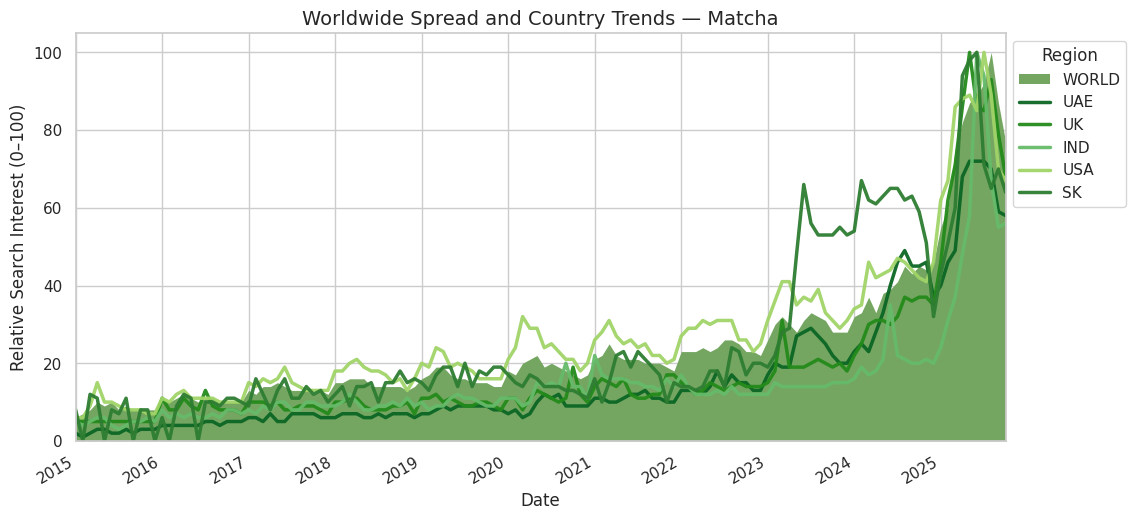

In [128]:
# --- Matcha: area + country lines ---
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import to_rgba

country_codes = ['AE','GB','IN','US','KR']
label_map = {'AE':'UAE','GB':'UK','IN':'IND','US':'USA','KR':'SK','WORLD':'WORLD'}

line_colors = ['#0b6623','#238a1a','#66bb6a','#a0d468','#2e7d32']  # visible green shades
area_color  = to_rgba('#74A662',0.25)

def get_keyword_columns(df,prefix,country_codes):
    cols=[c for c in df.columns if c.lower().startswith(prefix.lower())]
    world_col=next((c for c in cols if 'world' in c.lower()),None)
    country_cols=[]
    for code in country_codes:
        found=next((c for c in cols if c.upper().endswith('_'+code) or c.upper().endswith(code)),None)
        if found: country_cols.append((code,found))
    return world_col,country_cols

matcha_world_col, matcha_country_cols = get_keyword_columns(data,'matcha',country_codes)
matcha_df = pd.DataFrame(index=data.index)
if matcha_world_col: matcha_df['WORLD']=data[matcha_world_col]
for code,col in matcha_country_cols: matcha_df[label_map[code]]=data[col]

fig,ax=plt.subplots(figsize=(12,6))
if 'WORLD' in matcha_df: matcha_df['WORLD'].plot.area(ax=ax,color=area_color,alpha=1.0,linewidth=0)
for i,c in enumerate([x for x in matcha_df.columns if x!='WORLD']):
    matcha_df[c].plot(ax=ax,color=line_colors[i%len(line_colors)],linewidth=2.5,label=c,alpha=0.95)
ax.set_title("Worldwide Spread and Country Trends — Matcha",fontsize=14)
ax.set_ylabel("Relative Search Interest (0–100)")
ax.set_xlabel("Date")
ax.legend(title="Region",loc='upper left',bbox_to_anchor=(1,1))
ax.set_ylim(bottom=0)
fig.autofmt_xdate()
save_fig(fig,"fig_area_matcha_world_and_countries.png")
plt.show()


Saved pytrends_eda_outputs/fig_area_dubai_chocolate_world_and_countries.png


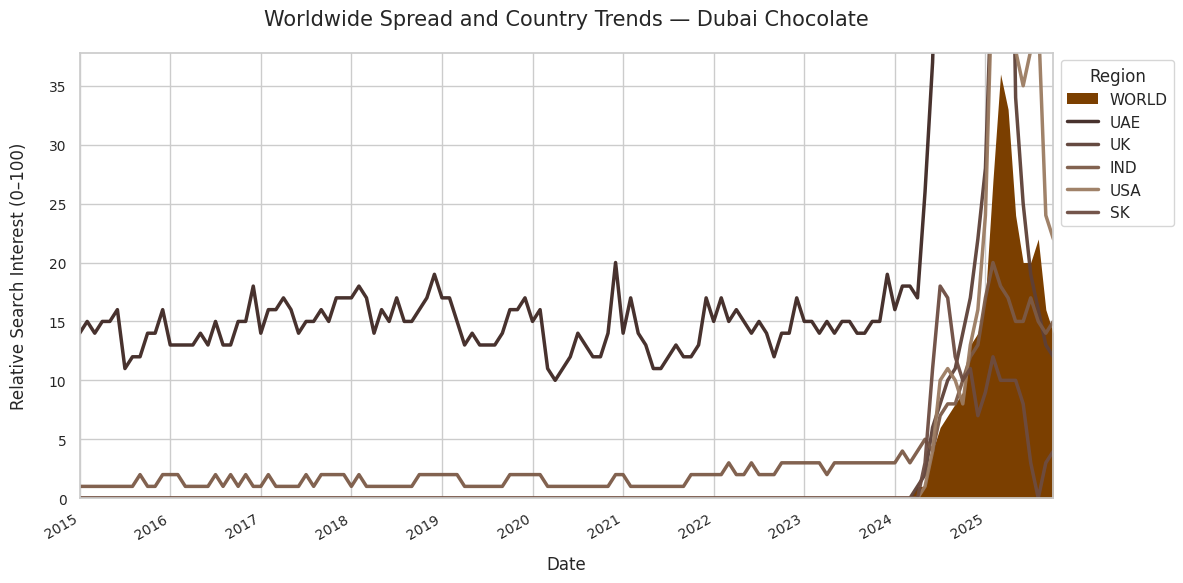

In [129]:
# --- Dubai Chocolate: area + country lines ---
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import to_rgba

country_codes = ['AE','GB','IN','US','KR']
label_map = {'AE':'UAE','GB':'UK','IN':'IND','US':'USA','KR':'SK','WORLD':'WORLD'}

line_colors = ['#3e2723','#5d4037','#7b5a46','#9b7b61','#6d4c41']  # browns (visible contrast)
area_color  = to_rgba('#7B3F00',0.20)

def get_keyword_columns(df,prefix,country_codes):
    cols=[c for c in df.columns if c.lower().startswith(prefix.lower())]
    world_col=next((c for c in cols if 'world' in c.lower()),None)
    country_cols=[]
    for code in country_codes:
        found=next((c for c in cols if c.upper().endswith('_'+code) or c.upper().endswith(code)),None)
        if found: country_cols.append((code,found))
    return world_col,country_cols

dubai_world_col, dubai_country_cols = get_keyword_columns(data,'dubai_chocolate',country_codes)
dubai_df = pd.DataFrame(index=data.index)
if dubai_world_col: dubai_df['WORLD']=data[dubai_world_col]
for code,col in dubai_country_cols: dubai_df[label_map[code]]=data[col]

fig, ax = plt.subplots(figsize=(12,6))

# Area layer for WORLD
if 'WORLD' in dubai_df:
    dubai_df['WORLD'].plot.area(ax=ax, color=area_color, alpha=1.0, linewidth=0, label='WORLD')

# Line plots for each country
for i, c in enumerate([x for x in dubai_df.columns if x != 'WORLD']):
    dubai_df[c].plot(ax=ax, color=line_colors[i % len(line_colors)], linewidth=2.5, label=c, alpha=0.95)

# Titles and labels
ax.set_title("Worldwide Spread and Country Trends — Dubai Chocolate", fontsize=15, pad=20)
ax.set_xlabel("Date", fontsize=12, labelpad=10)
ax.set_ylabel("Relative Search Interest (0–100)", fontsize=12, labelpad=15, rotation=90)
# ↑ labelpad increases spacing; rotation=90 keeps vertical; fontsize adjusts size

# Legend and limits
ax.legend(title="Region", loc='upper left', bbox_to_anchor=(1, 1))
ax.set_ylim(bottom=0)

# Style and save
ax.tick_params(axis='both', labelsize=10)
fig.autofmt_xdate()
plt.tight_layout()
save_fig(fig, "fig_area_dubai_chocolate_world_and_countries.png")
plt.show()